In [ ]:
import pandas as pd
import os
from pprint import pprint

data_path = "data"
csv_file = os.path.join(data_path, "01-12", "DrDoS_DNS.csv")

selected_columns = [
    "FlowID", "SourceIP", "SourcePort", "DestinationIP", 
    "DestinationPort", "Protocol", "Timestamp", "FlowDuration",
    "TotalFwdPackets"
]

df_selected = pd.read_csv(csv_file, usecols=selected_columns, nrows=1000)
df_selected.columns = df_selected.columns.str.strip().str.replace(' ', '')
df_dict = df_selected.to_dict(orient="records")


In [38]:
# Exibir o DataFrame selecionado
display(df_selected)

# Criar o DataFrame a partir do dicionário (df_dict criado anteriormente)
df_time_series = pd.DataFrame(df_dict)
print(df_time_series.columns)


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets
0,172.16.0.5-192.168.50.1-634-60495-17,172.16.0.5,634,192.168.50.1,60495,17,2018-12-01 10:51:39.813448,28415,97
1,172.16.0.5-192.168.50.1-60495-634-17,192.168.50.1,634,172.16.0.5,60495,17,2018-12-01 10:51:39.820842,2,2
2,172.16.0.5-192.168.50.1-634-46391-17,172.16.0.5,634,192.168.50.1,46391,17,2018-12-01 10:51:39.852499,48549,200
3,172.16.0.5-192.168.50.1-634-11894-17,172.16.0.5,634,192.168.50.1,11894,17,2018-12-01 10:51:39.890213,48337,200
4,172.16.0.5-192.168.50.1-634-27878-17,172.16.0.5,634,192.168.50.1,27878,17,2018-12-01 10:51:39.941151,32026,200
...,...,...,...,...,...,...,...,...,...
995,172.16.0.5-192.168.50.1-634-32698-17,172.16.0.5,634,192.168.50.1,32698,17,2018-12-01 10:52:38.896755,138696,200
996,172.16.0.5-192.168.50.1-32698-634-17,192.168.50.1,634,172.16.0.5,32698,17,2018-12-01 10:52:38.896884,2,2
997,172.16.0.5-192.168.50.1-634-58670-17,172.16.0.5,634,192.168.50.1,58670,17,2018-12-01 10:52:39.035865,30765,200
998,172.16.0.5-192.168.50.1-634-62860-17,172.16.0.5,634,192.168.50.1,62860,17,2018-12-01 10:52:39.066991,31150,200


Index(['Flow ID', ' Source IP', ' Source Port', ' Destination IP',
       ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration',
       ' Total Fwd Packets'],
      dtype='object')


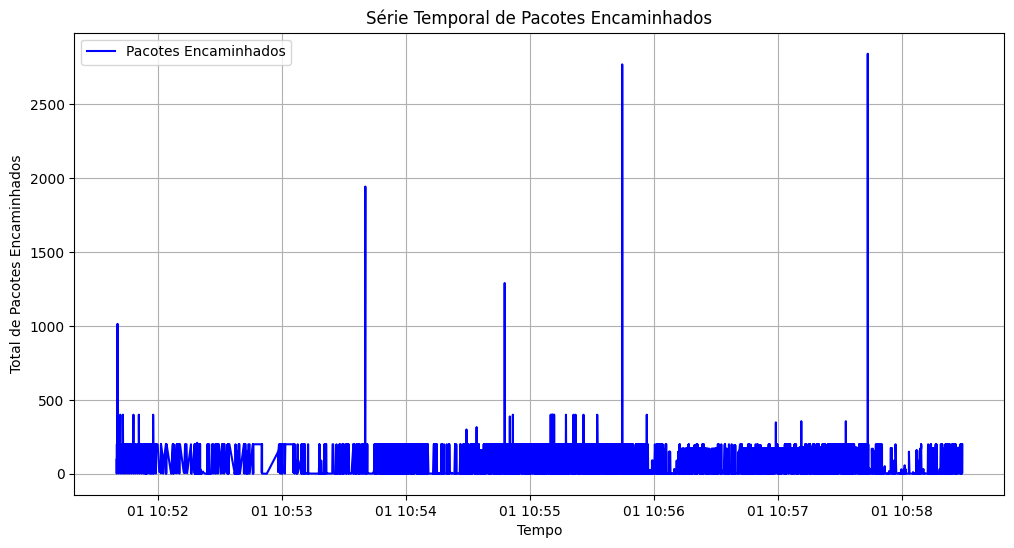

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# Criar o DataFrame a partir do dicionário (df_dict criado anteriormente)
df_time_series = pd.DataFrame(df_dict)

# Converter 'Timestamp' para formato datetime e definir como índice
df_time_series[" Timestamp"] = pd.to_datetime(df_time_series[" Timestamp"])
df_time_series.set_index(" Timestamp", inplace=True)

# Ordenar os dados pelo tempo para garantir coerência temporal
df_time_series = df_time_series.sort_index()

# Criar a série temporal usando "Total Fwd Packets"
plt.figure(figsize=(12, 6))
plt.plot(df_time_series.index, df_time_series[" Total Fwd Packets"], label="Pacotes Encaminhados", color="blue")

plt.xlabel("Tempo")
plt.ylabel("Total de Pacotes Encaminhados")
plt.title("Série Temporal de Pacotes Encaminhados")
plt.legend()
plt.grid()
plt.show()
